In [1]:
from google.colab import drive
import os
import shutil
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import nibabel as nib
drive.mount('/content/MyDrive/')
os.chdir('/content/MyDrive/MyDrive/IDS705_Final') #change to file path on your disk

Mounted at /content/MyDrive/


In [2]:
#Create Train / Val / Test Split
subfolders = os.listdir("Data/Train")
np.random.seed(101)
split = np.random.choice(["Train","Val","Test"], len(subfolders), p=[0.6, 0.2, 0.2])
train_ids = [subfolders[i] for i,v in enumerate(split) if v=="Train"]
val_ids = [subfolders[i] for i,v in enumerate(split) if v=="Val"]
test_ids = [subfolders[i] for i,v in enumerate(split) if v=="Test"]

In [3]:
#Helper Functions
def parse_tfrecord(example):
  """
  This function helps in parsing tfrecord files when creating a TF Dataset object
  """
  feature = {'image': tf.io.FixedLenFeature([240, 240, 155, 4], tf.float32),
             'label': tf.io.FixedLenFeature([240, 240, 155], tf.int64)}
  parsed_example = tf.io.parse_single_example(example, feature)
  return parsed_example

def get_image_and_label(features):
  """
  Extract Image and Label Object from tfrecord files
  """
  image, label = features['image'], features['label']
  return image, label

def get_dataset(tfrecord_names):
  """
  Create TF dataset files that can be fed into model functions
  """
  dataset = (tf.data.TFRecordDataset(tfrecord_names)
             .map(parse_tfrecord)
             .map(get_image_and_label))

  return dataset

In [4]:
#Create dataset objects
train_dataset = get_dataset([f'/content/MyDrive/MyDrive/IDS705_Final/Data/train_tf/{sf}.tfrecord' for sf in train_ids])
test_dataset = get_dataset([f'/content/MyDrive/MyDrive/IDS705_Final/Data/train_tf/{sf}.tfrecord' for sf in test_ids])
val_dataset = get_dataset([f'/content/MyDrive/MyDrive/IDS705_Final/Data/train_tf/{sf}.tfrecord' for sf in val_ids])
mini_dataset = get_dataset([f'/content/MyDrive/MyDrive/IDS705_Final/Data/train_tf/{sf}.tfrecord' for sf in subfolders[100:228]])
minival_dataset = get_dataset([f'/content/MyDrive/MyDrive/IDS705_Final/Data/train_tf/{sf}.tfrecord' for sf in subfolders[500:508]])

In [5]:
#loss functions
def dice_loss(y_true, y_pred):
  y_true = tf.one_hot(y_true, depth=5)
  numerator = 2 * tf.reduce_sum(y_true * y_pred)
  denominator = tf.reduce_sum(y_true + y_pred)
  return 1 - numerator / denominator

def bla(x,y):
  return x+y

def hecore_foundary(hemier):
  [i+3 for i in range(2)]
  return "walterwht"

In [6]:
#Ultra Basic

def gen_model(lr=1e-3):
    input_layer = tf.keras.layers.Input(shape=(240,240,155,4))

    x8 = tf.keras.layers.Conv3D( 8, 3, strides=(1,1,1), activation='relu', padding='same')(input_layer)
    x8 = tf.keras.layers.BatchNormalization()(x8)
    x8 = tf.keras.layers.Conv3D( 8, 3, strides=(2,2,2), activation='relu', padding='same')(x8)
    x8 = tf.keras.layers.BatchNormalization()(x8)

    x16 = tf.keras.layers.Conv3D(16, 3, strides=(1,1,1), activation='relu', padding='same')(x8)
    x16 = tf.keras.layers.BatchNormalization()(x16)
    x16 = tf.keras.layers.Conv3D(16, 3, strides=(2,2,2), activation='relu', padding='same')(x16)
    x16 = tf.keras.layers.BatchNormalization()(x16)

    x32 = tf.keras.layers.Conv3D(32, 3, strides=(1,1,1), activation='relu', padding='same')(x16)
    x32 = tf.keras.layers.BatchNormalization()(x32)
    x32 = tf.keras.layers.Conv3D(32, 3, strides=(2,2,2), activation='relu', padding='same')(x32)
    x32 = tf.keras.layers.BatchNormalization()(x32)
    
    x64 = tf.keras.layers.Conv3D(64, 3, strides=(1,1,1), activation='relu', padding='same')(x32)
    x64 = tf.keras.layers.BatchNormalization()(x64)
    x64 = tf.keras.layers.Conv3D(64, 3, strides=(2,2,2), activation='relu', padding='same')(x64)
    x64 = tf.keras.layers.BatchNormalization()(x64)

    x = tf.keras.layers.Conv3D(128, 3, strides=(1,1,1), activation='relu', padding='same')(x64)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv3D(128, 3, strides=(2,2,2), activation='relu', padding='same')(x64)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Conv3DTranspose(64, 3, strides=(2,2,2), activation='relu', padding='same')(x)
    x = tf.keras.layers.Cropping3D(cropping=((0,1), (0,1), (0,0)))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.concatenate([x,x64], axis=-1)
    x = tf.keras.layers.Conv3D(64, 3, strides=(1,1,1), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Conv3DTranspose(32, 3, strides=(2,2,2), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.concatenate([x,x32], axis=-1)
    x = tf.keras.layers.Conv3D(32, 3, strides=(1,1,1), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Conv3DTranspose(16, 3, strides=(2,2,2), activation='relu', padding='same')(x)
    x = tf.keras.layers.Cropping3D(cropping=((0,0), (0,0), (0,1)))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.concatenate([x,x16], axis=-1)
    x = tf.keras.layers.Conv3D(16, 3, strides=(1,1,1), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Conv3DTranspose(8, 3, strides=(2,2,2), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.concatenate([x,x8], axis=-1)
    x = tf.keras.layers.Conv3D(8, 3, strides=(1,1,1), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Conv3DTranspose(5, 3, strides=(2,2,2), activation='relu', padding='same')(x)
    x = tf.keras.layers.Cropping3D(cropping=((0,0), (0,0), (0,1)))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv3D(5, 3, strides=(1,1,1), activation='relu', padding='same')(x)
    
    x = tf.keras.layers.Softmax(axis=-1)(x)
    
    full_model = tf.keras.Model(inputs=input_layer, outputs=x)
    full_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='SparseCategoricalCrossentropy')
    return full_model

basic_model = gen_model()
basic_model.summary()
lr = 1e-3
mini_dataset_trainable = mini_dataset.shuffle(4).batch(4)
minival_dataset_validable = minival_dataset.batch(4)
train_dataset_trainable = train_dataset.shuffle(4).batch(4)
val_dataset_validable = val_dataset.batch(4)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 240, 1  0           []                               
                                55, 4)]                                                           
                                                                                                  
 conv3d (Conv3D)                (None, 240, 240, 15  872         ['input_1[0][0]']                
                                5, 8)                                                             
                                                                                                  
 batch_normalization (BatchNorm  (None, 240, 240, 15  32         ['conv3d[0][0]']                 
 alization)                     5, 8)                                                         

In [7]:
checkpoint_filepath = '/content/MyDrive/MyDrive/IDS705_Final/Models_02'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    save_best_only=True,
    monitor='val_loss',
    save_freq = 'epoch')
basic_model_history = basic_model.fit(train_dataset_trainable, epochs=6, callbacks=[model_checkpoint_callback], validation_batch_size=4, validation_data=val_dataset_validable)

Epoch 1/6
    187/Unknown - 841s 4s/step - loss: 0.4664WARNING:tensorflow:Can save best model only with val_loss available, skipping.
187/187 [==============================] - 842s 4s/step - loss: 0.4664
Epoch 2/6
187/187 [==============================] - 996s 5s/step - loss: 0.0779
Epoch 3/6
187/187 [==============================] - 1004s 5s/step - loss: 0.0400
Epoch 4/6
187/187 [==============================] - 1005s 5s/step - loss: 0.0374
Epoch 5/6
187/187 [==============================] - 995s 5s/step - loss: 0.0317
Epoch 6/6
187/187 [==============================] - 993s 5s/step - loss: 0.0281


In [9]:
basic_model.save('/content/MyDrive/MyDrive/IDS705_Final/Models_02_6epoch')

INFO:tensorflow:Assets written to: /content/MyDrive/MyDrive/IDS705_Final/Models_02_6epoch/assets


In [8]:
pred0 = basic_model.predict(minival_dataset_validable, batch_size=4)

In [ ]:
# loaded_model = gen_model()
# loaded_model.load_weights('/content/MyDrive/MyDrive/IDS705_Final/Models_00/')

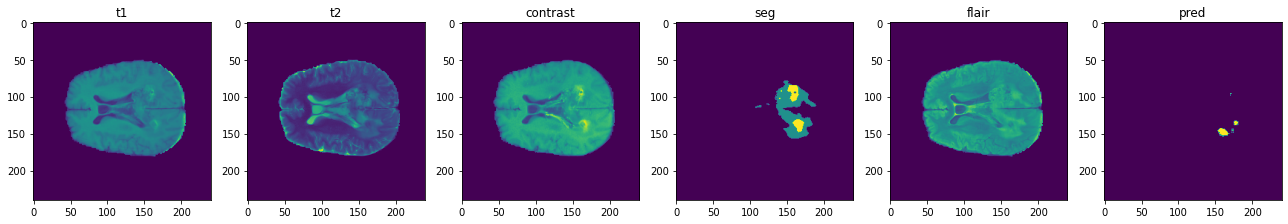

In [22]:
i=3
subfolders = os.listdir("Data/Train")
subfolder_id = 500 + i
subfolder_name = subfolders[subfolder_id]
img1 = nib.load(f'Data/Train/{subfolder_name}/{subfolder_name}_t1.nii.gz') #file_format - nifti
img2 = nib.load(f'Data/Train/{subfolder_name}/{subfolder_name}_t2.nii.gz') #file_format - nifti2
imgce = nib.load(f'Data/Train/{subfolder_name}/{subfolder_name}_t1ce.nii.gz') #file_format - ce
imgseg = nib.load(f'Data/Train/{subfolder_name}/{subfolder_name}_seg.nii.gz') #file_format - seg
imgflair = nib.load(f'Data/Train/{subfolder_name}/{subfolder_name}_flair.nii.gz') #file_format - flair
slice_no=85

fig,axs = plt.subplots(1,6,figsize=(18,5))
axs[0].imshow(img1.dataobj[:,:,slice_no])
axs[1].imshow(img2.dataobj[:,:,slice_no])
axs[2].imshow(imgce.dataobj[:,:,slice_no])
axs[3].imshow(imgseg.dataobj[:,:,slice_no])
axs[4].imshow(imgflair.dataobj[:,:,slice_no])
axs[5].imshow(pred0[i,:,:,slice_no,:].argmax(2))

axs[0].set_title("t1")
axs[1].set_title("t2")
axs[2].set_title("contrast")
axs[3].set_title("seg")
axs[4].set_title("flair")
axs[5].set_title("pred")
fig.tight_layout()